# Landsat Aquatic Reflectance <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[landsat_c2l2_ar](https://explorer.digitalearth.africa/landsat_c2l2_ar)


## Background


## Description



***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube

import numpy as np
import geopandas as gpd
from datacube.utils.geometry import Geometry
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.spatial import xr_rasterize

from deafrica_tools.waterbodies import (
    get_geohashes,
    get_waterbodies,
    get_waterbody,
    get_time_series,
)

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="landsat_c2l2_ar")

### List measurements

We can further inspect the data available for each Landsat product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [3]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['landsat_c2l2_ar']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
RHORC_B1,RHORC_B1,int16,1,-9999.0,"[band_1, rh_coastal]",NaN
RHORC_B2,RHORC_B2,int16,1,-9999.0,"[band_2, rh_blue]",NaN
RHORC_B3,RHORC_B3,int16,1,-9999.0,"[band_3, rh_green]",NaN
RHORC_B4,RHORC_B4,int16,1,-9999.0,"[band_4, rh_red]",NaN
RHORC_B5,RHORC_B5,int16,1,-9999.0,"[band_5, rh_nir08]",NaN
RHORC_B6,RHORC_B6,int16,1,-9999.0,"[band_6, rh_swir16]",NaN
RHORC_B7,RHORC_B7,int16,1,-9999.0,"[band_7, rh_swir22]",NaN
AR_B1,AR_B1,int16,1,-9999.0,"[ar_band_1, coastal]",NaN
AR_B2,AR_B2,int16,1,-9999.0,"[ar_band_2, blue]",NaN


### Define the Area of Interest

In [4]:
# Set the central latitude and longitude
lat = 14.81405
lon = -17.22656

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box coordinates
xlim = (lon-buffer, lon+buffer)
ylim =  (lat+buffer, lat-buffer)

# Preview area on a map
display_map(xlim, ylim)

#### Identify the water bodies within the area of interest from the waterbodies functions

In [5]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")
polygons

,id,area_m2,length_m,UID,WB_ID,perim_m,timeseries,geometry
0,DEAfrica_Waterbodies.34237,1.080000e+04,240.000000,edeevdx1vr,34237,600,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.32692 14.73665, -17.32661 ..."
1,DEAfrica_Waterbodies.34238,5.400000e+03,120.000000,edeevdz6h0,34238,360,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.32630 14.73762, -17.32599 ..."
2,DEAfrica_Waterbodies.34239,1.080000e+04,180.000000,edeevg82tv,34239,600,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.32505 14.74175, -17.32474 ..."
3,DEAfrica_Waterbodies.34241,2.610000e+04,299.999878,edeexwzxub,34241,840,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.23799 14.71745, -17.23768 ..."
4,DEAfrica_Waterbodies.34242,1.170000e+04,227.683991,edeexz0kr9,34242,660,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.23768 14.71770, -17.23675 ..."
5,DEAfrica_Waterbodies.34256,1.611000e+05,706.113012,edeg8n7dfv,34256,2700,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.22276 14.71527, -17.22214 ..."
6,DEAfrica_Waterbodies.34257,1.980000e+04,299.606299,edeg9rpzk6,34257,900,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.16026 14.71818, -17.15964 ..."
7,DEAfrica_Waterbodies.34258,9.900000e+03,120.000000,edeg9rqsrp,34258,420,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.16306 14.71867, -17.16182 ..."
8,DEAfrica_Waterbodies.34259,2.520000e+04,254.911804,edegb87dkb,34259,780,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.20037 14.72426, -17.19975 ..."
9,DEAfrica_Waterbodies.34260,1.908000e+05,1008.294717,edegbcujf5,34260,4140,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.18825 14.73762, -17.18763 ..."


#### Display the water bodies within the area of interest

In [6]:
polygons.explore()

#### Using the UUID select a water body

In [7]:
selected_waterbody_geohash = "edesrvwf0t"

geopolygon_gdf = get_waterbody(selected_waterbody_geohash)
geopolygon_gdf

,id,area_m2,length_m,UID,WB_ID,perim_m,timeseries,geometry
0,DEAfrica_Waterbodies.34282,4.259700e+06,4812.3086,edesrvwf0t,34282,16380,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((-17.20410 14.85232, -17.20379 ..."


#### Display the selected water body

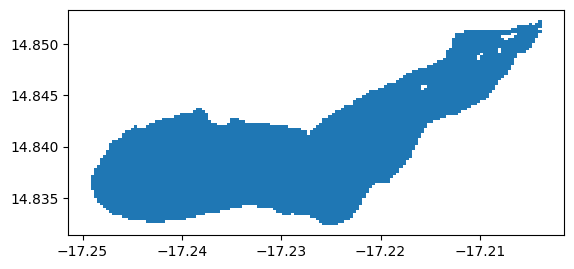

In [8]:
geopolygon_gdf.plot();

#### Load the aquatic reflectances and Wofs dataset

In [9]:
# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])
time_range = ('2020', '2021')

# load data
ds_aq_range = dc.load(
    product="landsat_c2l2_ar",
    measurements=['red', 'green', 'blue','nir08','water'],
    resolution=(-30, 30),
    y = lat_range, 
    x = lon_range,
    time=time_range,
    output_crs="EPSG:6933",
    group_by="solar_day")

ds_aq_range = ds_aq_range.rename({'nir08':'nir'})

# load data
ds_wofs_range = dc.load(
    product="wofs_ls",
    measurements=['water'],
    like=ds_aq_range.geobox,
    time=time_range,
    group_by="solar_day",
    platform= "landsat-8",
    collection_category="T1"
)

#### Filter the dataset to get matching dates

In [10]:
ds_aq_range = ds_aq_range.isel(time=ds_aq_range.time.isin(ds_wofs_range.time))
ds_wofs_range = ds_wofs_range.isel(time=ds_wofs_range.time.isin(ds_aq_range.time))

#### Pixel to area calculation

In [11]:
pixel_length = ds_wofs_range.geobox.resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

#### Clip only the water body area

In [12]:
ds_aq_clip = xr_rasterize(gdf=geopolygon_gdf, da=ds_aq_range,crs=ds_aq_range.crs)
ds_aq_range = ds_aq_range.where(ds_aq_clip)
ds_wofs_range = ds_wofs_range.where(ds_aq_clip)

#### Select the timestep to use

In [13]:
timestep = 3

#### select only pixel with water

In [14]:
ds_wofs_range_water = ds_wofs_range.where(ds_wofs_range.water == 128, np.nan)
ds_range_water = ds_aq_range.where(ds_aq_range.water == 1, np.nan)
 
ds_wofs_stats = (ds_wofs_range_water.water==128).isel(time=timestep).astype(int)
ds_aq_stats = (ds_aq_range.water==1).isel(time=timestep).astype(int)

#### Plotting change WOFS and Aquatic Reflectances

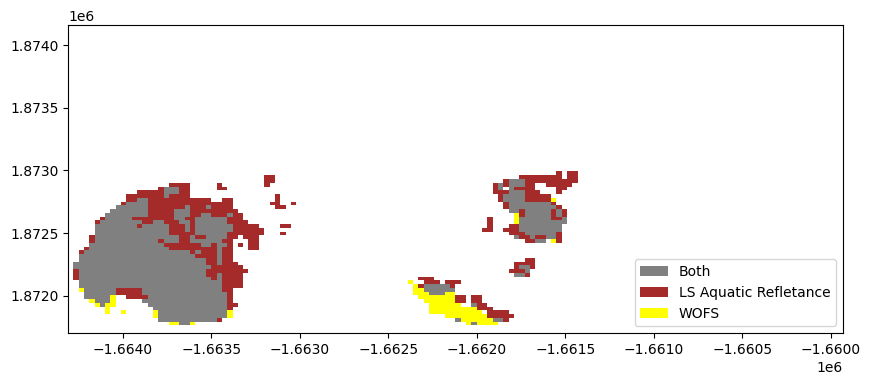

In [15]:
change = ds_wofs_stats-ds_aq_stats
wofs = change.where(change == 1)
both = change.where((change == 0) & (ds_wofs_range_water.water==128).isel(time=timestep))
ls_aquatic = change.where(change == -1)

wofs_color = "Yellow"
both_color = "Gray"
ls_aquatic_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

wofs.plot.imshow(
    cmap=ListedColormap([wofs_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
ls_aquatic.plot.imshow(
    cmap=ListedColormap([ls_aquatic_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

both.plot.imshow(cmap=ListedColormap([both_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=both_color),
        Patch(facecolor=ls_aquatic_color),
        Patch(facecolor=wofs_color),
    ],
    [
        f"Both",
        f"LS Aquatic Refletance",
        f"WOFS",
    ],
    loc="lower right",
)

plt.title("");

#### Plot WOFS and Landsat Aquatic Separately

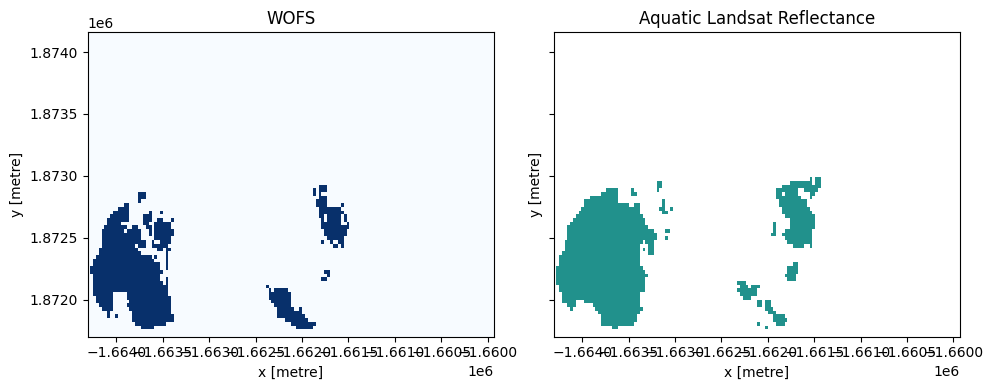

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
(ds_wofs_range_water==128).isel(time=timestep).water.plot(add_colorbar=False, cmap='Blues', ax=ax[0])
ds_range_water.isel(time=timestep).water.plot(add_colorbar=False, ax=ax[1])

ax[0].set_title('WOFS')
ax[1].set_title('Aquatic Landsat Reflectance')

plt.tight_layout();
plt.show()

#### Comparing Aquatic Reflectance and WOFS

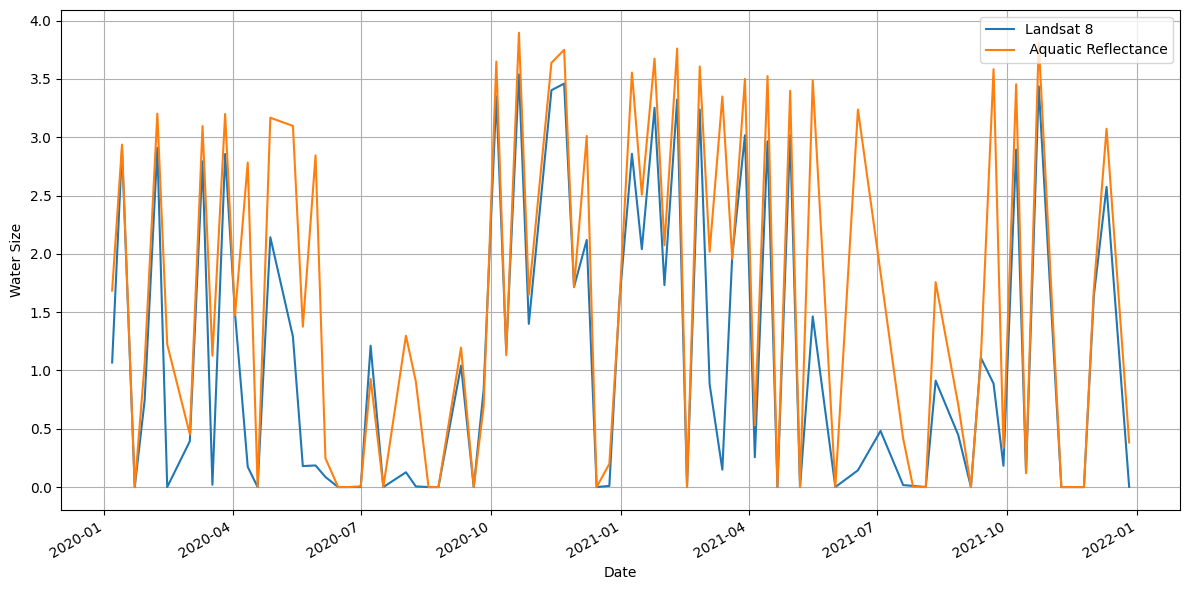

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

((ds_wofs_range_water.water == 128).sum(dim=['x', 'y']) * area_per_pixel).plot(label='Landsat 8')
(ds_range_water.water.sum(dim=['x', 'y']) * area_per_pixel).plot(label=' Aquatic Reflectance')


plt.ylabel('Water Size')
plt.xlabel('Date')
plt.grid()
plt.title('')
plt.legend(loc="upper right")


plt.tight_layout();
plt.show()

### Water Quality Index

##### Load landsat 8/9 data

In [18]:
ds_ls_range = dc.load(product="ls8_sr",
              measurements=['red', 'green', 'blue','nir'],
              like=ds_aq_range.geobox,
              time=time_range,
              group_by="solar_day"
             )
ds_ls_range = ds_ls_range.where(ds_aq_clip)
ds_ls_range = ds_ls_range.isel(time=ds_ls_range.time.isin(ds_aq_range.time))

## NDTI

In [19]:
ds_aq_range = calculate_indices(ds_aq_range, index="NDTI", satellite_mission="ls")
ds_ls_range = calculate_indices(ds_ls_range, index="NDTI", satellite_mission="ls")

#### Calculate the area Aquatic Reflectance, MNDWI AND WOfS

In [20]:
ds_aq_water_area = ds_aq_range.NDTI.mean(dim=['x', 'y']) * area_per_pixel
ds_ls_water_area = ds_ls_range.NDTI.mean(dim=['x', 'y']) * area_per_pixel

#### Plot seasonal time series from the 

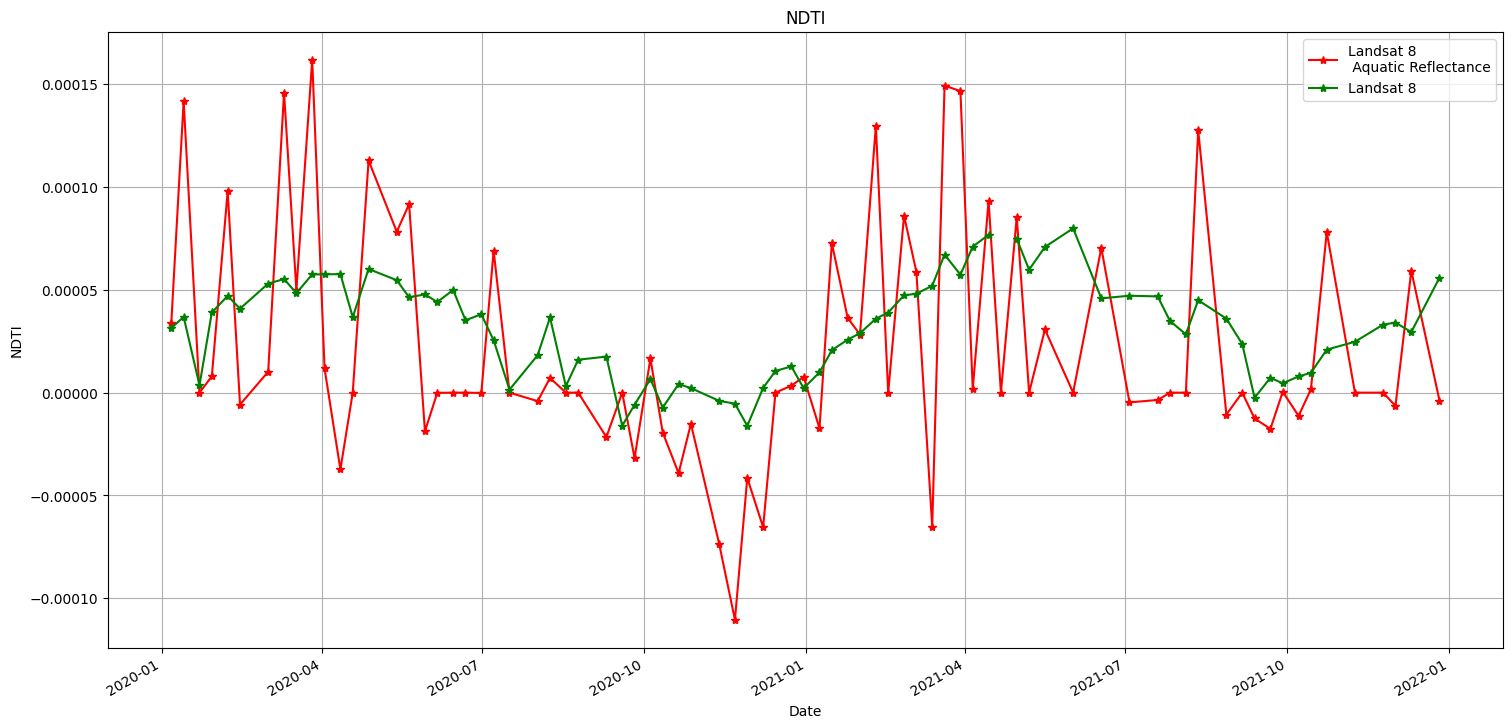

In [21]:
ds_ls_ndti_area = ds_ls_range.NDTI.mean(dim=['x', 'y']) * area_per_pixel
ds_aq_ndti_area = ds_aq_range.NDTI.mean(dim=['x', 'y']) * area_per_pixel

plt.figure(figsize=(18, 8))
ds_aq_ndti_area.plot(marker='*', color='red', label='Landsat 8 \n Aquatic Reflectance')
ds_ls_ndti_area.plot(marker='*', color='green', label='Landsat 8')

plt.ylabel('NDTI')
plt.xlabel('Date')
plt.grid()
plt.title('NDTI')
plt.legend(loc="upper right")
plt.show()

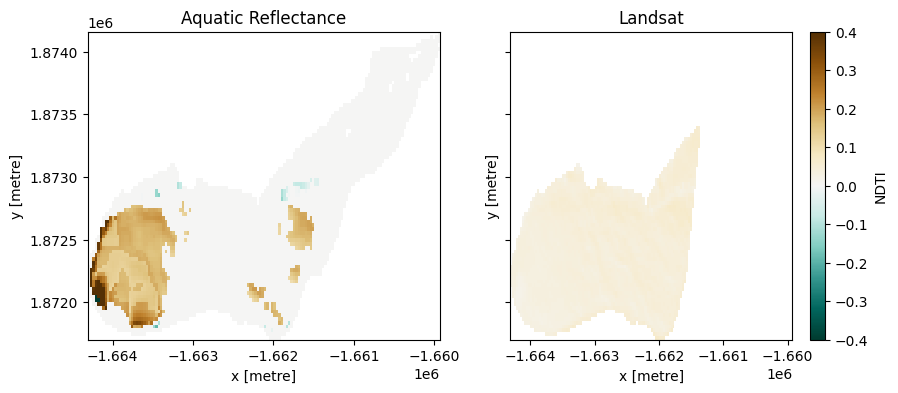

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
cmap='BrBG_r'

vmin=-0.4
vmax=0.4

ds_aq_range.NDTI.isel(time=timestep).plot(ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
ds_ls_range.NDTI.isel(time=timestep).plot(ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax);

ax[0].set_title('Aquatic Reflectance')
ax[1].set_title('Landsat')
plt.show()

### Normalized Difference Suspended Sediment Index (NDSSI)

In [23]:
# Function to calculate NDSSI value
def NDSSI(dataset):
    return (dataset.blue - dataset.nir) / (dataset.blue + dataset.nir)

In [24]:
# Calculate the NDSSI value for Landsat 8, using water extent to mask
ndssi_aq_range = NDSSI(ds_aq_range)
ndssi_ls_range = NDSSI(ds_ls_range)

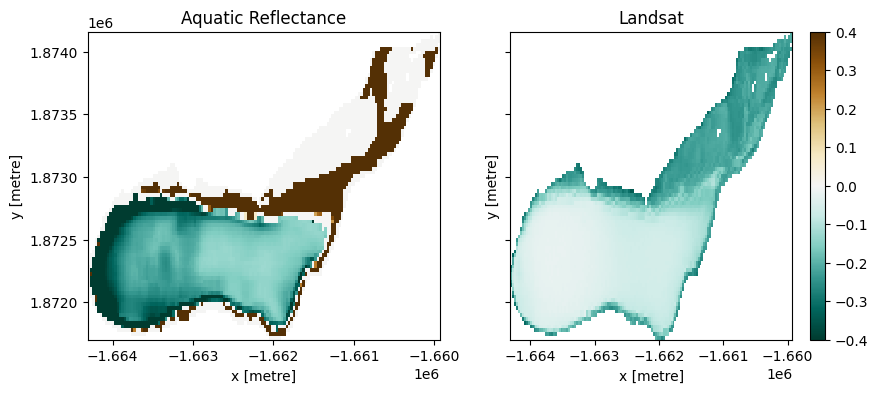

In [25]:
timestep=9
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
cmap='BrBG_r'

ndssi_aq_range.isel(time=timestep).plot(ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
ndssi_ls_range.isel(time=timestep).plot(ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax);

ax[0].set_title('Aquatic Reflectance')
ax[1].set_title('Landsat')
plt.show()

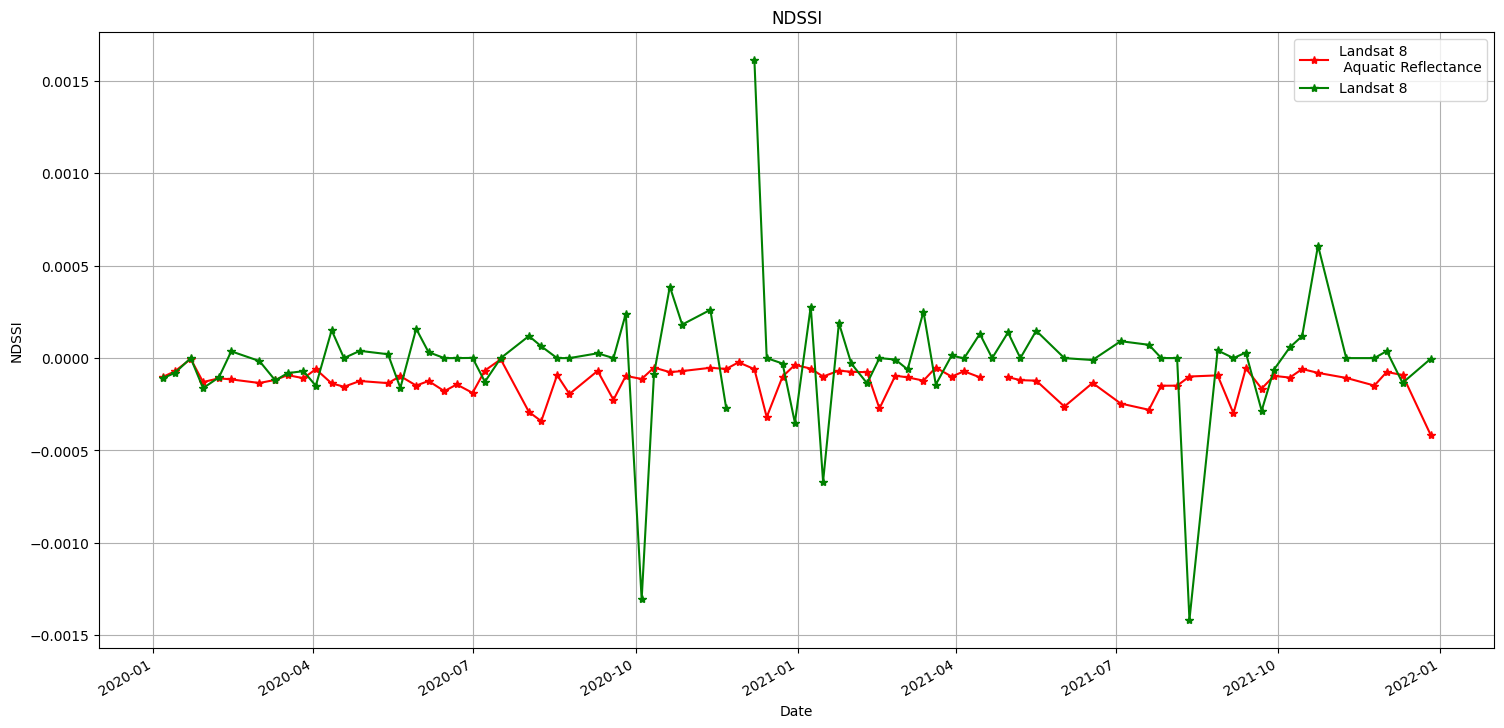

In [26]:
ds_ls_ndssi_area = ndssi_aq_range.mean(dim=['x', 'y']) * area_per_pixel
ds_aq_ndssi_area = ndssi_ls_range.mean(dim=['x', 'y']) * area_per_pixel

plt.figure(figsize=(18, 8))
ds_aq_ndssi_area.plot(marker='*', color='red', label='Landsat 8 \n Aquatic Reflectance')
ds_ls_ndssi_area.plot(marker='*', color='green', label='Landsat 8')

plt.ylabel('NDSSI')
plt.xlabel('Date')
plt.grid()
plt.title('NDSSI')
plt.legend(loc="upper right")
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [27]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [28]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-04-25'